# **Lab 7.2 CNN**

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return `DataLoader()` and print the information about the Dataset.
This function must load only a pair of classes from the entire dataset.
Please ensure that the final image is in grayscale and has a size of 28x28.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomRotation(),`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>)

In [54]:
def load_data(path, class_names):
    ### START CODE HERE ###
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1),
        transforms.Pad(27, padding_mode='reflect'),
        transforms.RandomRotation(degrees=15),
        transforms.CenterCrop(28)
    ])

    dataset = ImageFolder(path, transform=transform)

    class_to_idx = dataset.class_to_idx
    selected_classes = [class_to_idx[c] for c in class_names]

    indices = [i for i, (path, label) in enumerate(dataset.samples) if label in selected_classes]
    subset_dataset = Subset(dataset, indices)

    test_split = 0.3
    test_size = int(test_split * len(subset_dataset))
    train_size = len(subset_dataset) - test_size

    train_dataset, test_dataset = torch.utils.data.random_split(subset_dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

    print("📃 Train Dataset Information:")
    class_counts_train = {cls: 0 for cls in class_names}
    for _, label in train_dataset:
        class_name = dataset.classes[label]
        class_counts_train[class_name] += 1

    for cls_name, count in class_counts_train.items():
        print(f"\tNumber of images in class {cls_name}: {count}")
    print(f"\tTotal number of training samples: {len(train_dataset)}")

    print("\n📃 Test Dataset Information:")
    class_counts_test = {cls: 0 for cls in class_names}
    for _, label in test_dataset:
        class_name = dataset.classes[label]
        class_counts_test[class_name] += 1

    for cls_name, count in class_counts_test.items():
        print(f"\tNumber of images in class {cls_name}: {count}")
    print(f"\tTotal number of test samples: {len(test_dataset)}")

    ### END CODE HERE ###
    
    return train_loader, test_loader

Use your `load_data()` function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class 0: 313
	Number of images in class 1: 308
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 75
	Number of images in class 1: 81
	Number of testing samples: 156
```


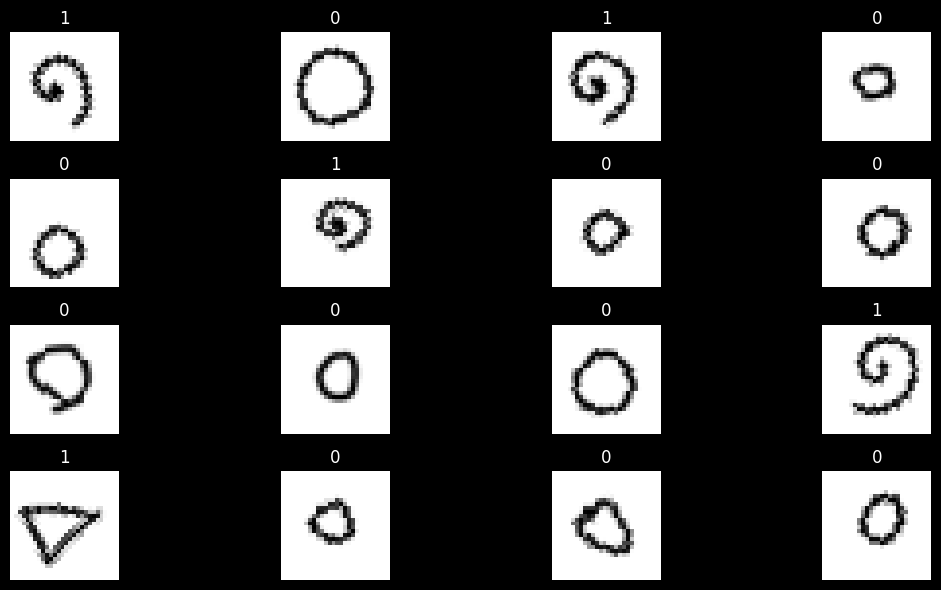

</details>

In [13]:
def imshow_grid(batch, labels):
    
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))

    for i in range(16):
        image = batch[i].squeeze().numpy()
        label = labels[i]

        ax = axes[i // 4, i % 4]
        ax.imshow(image, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"{label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

📃 Train Dataset Information:
	Number of images in class 0: 276
	Number of images in class 1: 268
	Total number of training samples: 544

📃 Test Dataset Information:
	Number of images in class 0: 112
	Number of images in class 1: 121
	Total number of test samples: 233


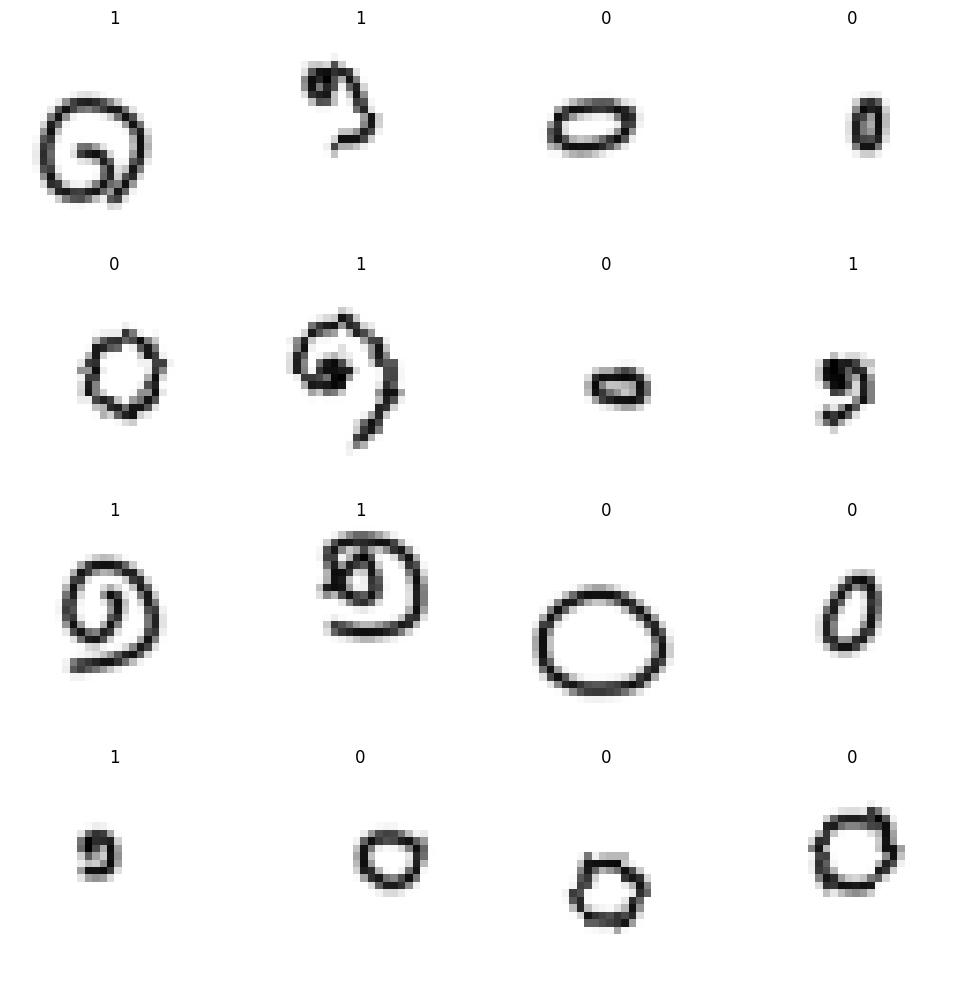

In [36]:
### START CODE HERE ###

path = r'C:\Users\Nickv\Documents\ImageProcessing\Week7\lab7_2_thai-handwriting-number\thai-handwriting-number.appspot.com'
class_names = ['0', '1']
train_loader, test_loader = load_data(path, class_names)
batch, labels = next(iter(train_loader))
imshow_grid(batch, labels)

### END CODE HERE ###

📃 Train Dataset Information:
	Number of images in class 0: 271
	Number of images in class 1: 270
	Number of images in class 2: 285
	Number of images in class 3: 286
	Number of images in class 4: 259
	Number of images in class 5: 274
	Number of images in class 6: 267
	Number of images in class 7: 276
	Number of images in class 8: 264
	Number of images in class 9: 266
	Total number of training samples: 2718

📃 Test Dataset Information:
	Number of images in class 0: 117
	Number of images in class 1: 119
	Number of images in class 2: 104
	Number of images in class 3: 102
	Number of images in class 4: 129
	Number of images in class 5: 114
	Number of images in class 6: 121
	Number of images in class 7: 112
	Number of images in class 8: 124
	Number of images in class 9: 122
	Total number of test samples: 1164


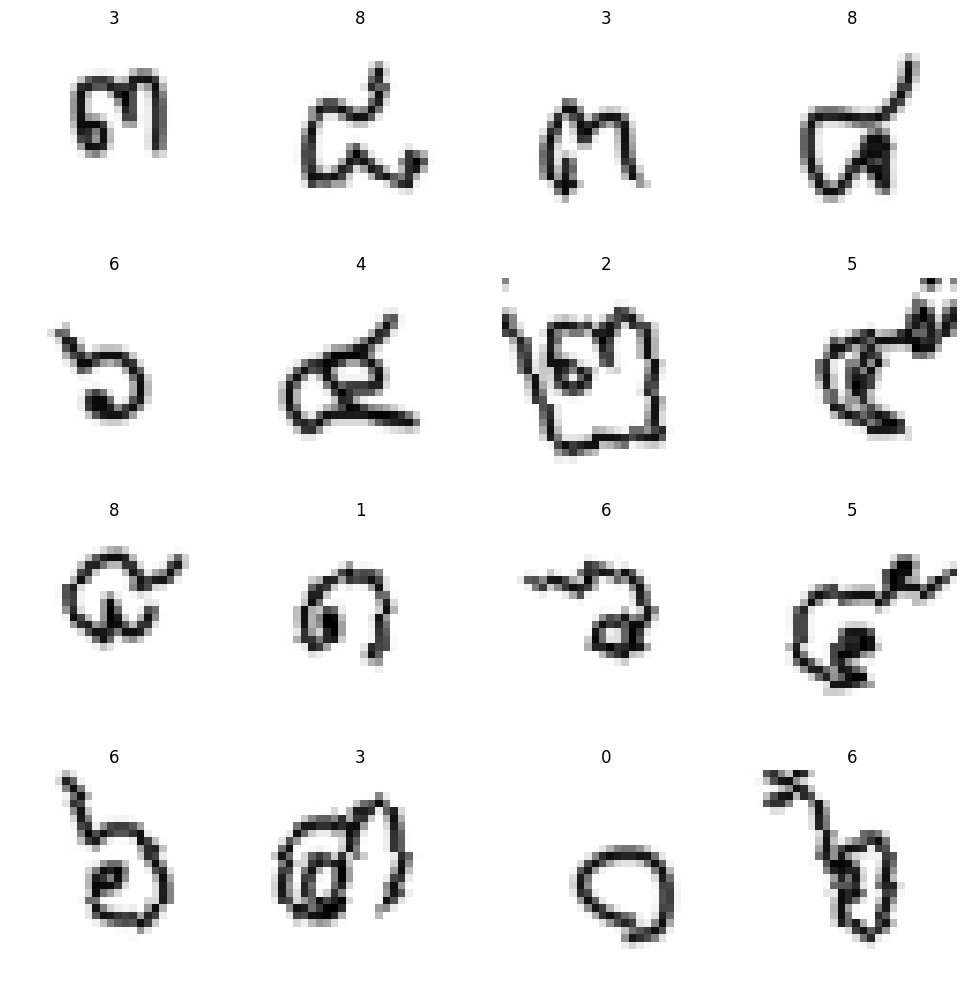

In [57]:
path = r'C:\Users\Nickv\Documents\ImageProcessing\Week7\lab7_2_thai-handwriting-number\thai-handwriting-number.appspot.com'
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
train_loader, test_loader = load_data(path, class_names)
batch, labels = next(iter(train_loader))
imshow_grid(batch, labels)

### **Create Models**
**CustomLeNet**:
- **Input**:  RGB images
- **Architecture**: Multiple convolutional layers with ReLU activations, followed by fully connected layers with ReLU activations
- **Description**: This is a convolutional neural network with two convolutional layers followed by two fully connected layers. It applies convolutional operations with ReLU activations, followed by flattening the output and passing through fully connected layers with ReLU activations. Finally, it produces a single neuron output with sigmoid activation.


In [58]:
### START CODE HERE ###
class CustomLeNet(nn.Module):
    def __init__(self):
        super(CustomLeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        
        x = x.view(-1, 32 * 4 * 4)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x)) 
        
        x = self.sigmoid(self.fc3(x))
        
        return x

### END CODE HERE ###

In [62]:
#For 10 classes
class CustomLeNet(nn.Module):
    def __init__(self):
        super(CustomLeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        
        x = x.view(-1, 32 * 5 * 5)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x)) 
        
        x = self.fc3(x)
        
        return x



Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the training loss/accuracy, test loss/accuracy. Additionally, it should save the model at the last epoch.

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>)


In [60]:
def train(model,opt,loss_fn,train_loader,test_loader,epochs=10,checkpoint_path=None,device='cpu'):
    ### START CODE HERE ###
    print("🤖 Training on", device)
    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        avg_train_loss = 0.0
        step = 0
        train_bar = tqdm(train_loader, desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        
        for images, gt in train_bar:
            images = images.to(device)
            gt = gt.to(device)

            opt.zero_grad()
            output = model(images)
            loss = loss_fn(output, gt)
            loss.backward()
            opt.step()

            avg_train_loss += loss.item()
            step += 1

            train_bar.set_postfix(loss=loss.item())

        avg_train_loss /= step
        
        model.eval()
        avg_test_loss = 0.0
        test_bar = tqdm(test_loader, desc='📄 Testing', unit='batch')
            
        for images, gt in test_bar:
            images = images.to(device)
            gt = gt.to(device)
            output = model(images)
            
            loss = loss_fn(output, gt)
            avg_test_loss += loss.item()

        avg_test_loss /= len(test_loader)
    
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

        with torch.no_grad():
            sample_images, sample_gt = next(iter(test_loader))
            sample_images = sample_images.to(device)
            sample_gt = sample_gt.to(device)
            sample_output = model(sample_images)
            sample_preds = torch.argmax(sample_output, dim=1)

            print(f"Sample Predictions: {sample_preds.cpu().numpy()}, Sample Targets: {sample_gt.cpu().numpy()}")

        if checkpoint_path:
            torch.save(model.state_dict(), f"{checkpoint_path}_epoch_{epoch+1}.pth")

    print("🏁 Training completed.")

    ### END CODE HERE ###

Use your `train()` function to train models.

In [28]:
### START CODE HERE ###
import torch.optim as optim

model = CustomLeNet()
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
train(model, opt, loss_fn, train_loader, test_loader, epochs=20, checkpoint_path='checkpoint/model', device='cuda' if torch.cuda.is_available() else 'cpu')

### END CODE HERE ###

🤖 Training on cuda


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.09batch/s]


Epoch [1/20], Train Loss: 0.2504, Test Loss: 0.2487
Sample Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.38batch/s]


Epoch [2/20], Train Loss: 0.2418, Test Loss: 0.2290
Sample Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.41batch/s]


Epoch [3/20], Train Loss: 0.1893, Test Loss: 0.1479
Sample Predictions: [0 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.08batch/s]


Epoch [4/20], Train Loss: 0.1495, Test Loss: 0.1384
Sample Predictions: [0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.26batch/s]


Epoch [5/20], Train Loss: 0.1130, Test Loss: 0.1039
Sample Predictions: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.33batch/s]


Epoch [6/20], Train Loss: 0.0979, Test Loss: 0.1096
Sample Predictions: [0 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.40batch/s]


Epoch [7/20], Train Loss: 0.0966, Test Loss: 0.1259
Sample Predictions: [1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.16batch/s]


Epoch [8/20], Train Loss: 0.0884, Test Loss: 0.0875
Sample Predictions: [0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.46batch/s]


Epoch [9/20], Train Loss: 0.0759, Test Loss: 0.1060
Sample Predictions: [0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:01<00:00,  7.98batch/s]


Epoch [10/20], Train Loss: 0.0806, Test Loss: 0.0856
Sample Predictions: [0 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.31batch/s]


Epoch [11/20], Train Loss: 0.0652, Test Loss: 0.0835
Sample Predictions: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 1 1 0 0], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.12batch/s]


Epoch [12/20], Train Loss: 0.0710, Test Loss: 0.0793
Sample Predictions: [1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.39batch/s]


Epoch [13/20], Train Loss: 0.0661, Test Loss: 0.0737
Sample Predictions: [1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.60batch/s]


Epoch [14/20], Train Loss: 0.0602, Test Loss: 0.0845
Sample Predictions: [0 1 0 0 1 0 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.40batch/s]


Epoch [15/20], Train Loss: 0.0648, Test Loss: 0.0866
Sample Predictions: [0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.25batch/s]


Epoch [16/20], Train Loss: 0.0579, Test Loss: 0.0808
Sample Predictions: [1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.07batch/s]


Epoch [17/20], Train Loss: 0.0520, Test Loss: 0.0852
Sample Predictions: [0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.21batch/s]


Epoch [18/20], Train Loss: 0.0557, Test Loss: 0.0866
Sample Predictions: [0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.28batch/s]


Epoch [19/20], Train Loss: 0.0501, Test Loss: 0.0686
Sample Predictions: [0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


📄 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.42batch/s]


Epoch [20/20], Train Loss: 0.0480, Test Loss: 0.0760
Sample Predictions: [0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1], Sample Targets: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0]
🏁 Training completed.


In [64]:
import torch.optim as optim

model = CustomLeNet()
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path='checkpoint/model', device='cuda' if torch.cuda.is_available() else 'cpu')

🤖 Training on cuda


📄 Testing: 100%|██████████| 37/37 [00:07<00:00,  5.05batch/s]


Epoch [1/10], Train Loss: 2.1327, Test Loss: 1.6909
Sample Predictions: [7 1 1 5 0 1 8 1 9 1 5 8 6 6 9 6 3 1 3 5 5 5 2 2 7 1 6 1 6 2 7 5], Sample Targets: [7 2 1 4 1 1 3 6 0 1 1 8 6 5 4 6 2 4 0 5 1 8 3 0 9 2 6 3 2 2 3 0]


📄 Testing: 100%|██████████| 37/37 [00:02<00:00, 18.21batch/s]


Epoch [2/10], Train Loss: 1.5387, Test Loss: 1.3890
Sample Predictions: [3 2 1 1 1 2 0 2 0 1 5 8 6 0 4 6 2 4 0 5 5 8 7 0 0 2 0 1 2 2 3 8], Sample Targets: [7 2 1 4 1 1 3 6 0 1 1 8 6 5 4 6 2 4 0 5 1 8 3 0 9 2 6 3 2 2 3 0]


📄 Testing: 100%|██████████| 37/37 [00:01<00:00, 18.80batch/s]


Epoch [3/10], Train Loss: 1.2501, Test Loss: 1.2017
Sample Predictions: [3 2 6 4 0 6 0 2 0 1 5 8 6 9 4 6 2 4 3 5 1 8 2 3 7 2 9 3 2 2 3 0], Sample Targets: [7 2 1 4 1 1 3 6 0 1 1 8 6 5 4 6 2 4 0 5 1 8 3 0 9 2 6 3 2 2 3 0]


📄 Testing: 100%|██████████| 37/37 [00:01<00:00, 18.85batch/s]


Epoch [4/10], Train Loss: 1.0691, Test Loss: 1.0447
Sample Predictions: [3 2 1 4 1 1 0 6 9 1 1 8 6 0 4 6 2 4 0 5 1 8 3 0 9 1 0 0 2 2 3 0], Sample Targets: [7 2 1 4 1 1 3 6 0 1 1 8 6 5 4 6 2 4 0 5 1 8 3 0 9 2 6 3 2 2 3 0]


📄 Testing: 100%|██████████| 37/37 [00:01<00:00, 18.70batch/s]


Epoch [5/10], Train Loss: 0.9670, Test Loss: 0.9351
Sample Predictions: [7 2 1 5 1 1 0 2 6 1 5 8 6 9 4 6 2 4 0 5 1 5 7 0 9 2 9 0 2 2 3 0], Sample Targets: [7 2 1 4 1 1 3 6 0 1 1 8 6 5 4 6 2 4 0 5 1 8 3 0 9 2 6 3 2 2 3 0]


📄 Testing: 100%|██████████| 37/37 [00:01<00:00, 18.74batch/s]


Epoch [6/10], Train Loss: 0.8836, Test Loss: 0.8814
Sample Predictions: [7 2 1 4 0 6 0 6 6 1 1 8 6 0 4 6 2 4 0 5 1 8 7 0 9 2 0 0 2 2 3 0], Sample Targets: [7 2 1 4 1 1 3 6 0 1 1 8 6 5 4 6 2 4 0 5 1 8 3 0 9 2 6 3 2 2 3 0]


📄 Testing: 100%|██████████| 37/37 [00:02<00:00, 17.98batch/s]


Epoch [7/10], Train Loss: 0.8121, Test Loss: 0.9091
Sample Predictions: [7 2 1 4 3 0 0 6 6 1 1 8 6 0 4 6 2 4 0 4 1 8 3 0 9 2 0 0 2 2 3 0], Sample Targets: [7 2 1 4 1 1 3 6 0 1 1 8 6 5 4 6 2 4 0 5 1 8 3 0 9 2 6 3 2 2 3 0]


📄 Testing: 100%|██████████| 37/37 [00:01<00:00, 18.65batch/s]


Epoch [8/10], Train Loss: 0.7416, Test Loss: 0.8039
Sample Predictions: [9 2 1 4 0 1 0 2 6 1 1 8 6 0 4 6 2 4 0 5 1 8 3 0 9 2 0 0 2 2 3 0], Sample Targets: [7 2 1 4 1 1 3 6 0 1 1 8 6 5 4 6 2 4 0 5 1 8 3 0 9 2 6 3 2 2 3 0]


📄 Testing: 100%|██████████| 37/37 [00:01<00:00, 19.08batch/s]


Epoch [9/10], Train Loss: 0.7001, Test Loss: 0.7918
Sample Predictions: [7 2 6 4 0 1 0 6 6 1 1 8 6 9 4 6 2 4 0 5 1 8 3 0 4 2 9 0 2 2 3 0], Sample Targets: [7 2 1 4 1 1 3 6 0 1 1 8 6 5 4 6 2 4 0 5 1 8 3 0 9 2 6 3 2 2 3 0]


📄 Testing: 100%|██████████| 37/37 [00:02<00:00, 18.49batch/s]

Epoch [10/10], Train Loss: 0.6557, Test Loss: 0.7867
Sample Predictions: [7 2 1 5 1 1 0 2 5 1 1 8 6 6 4 6 2 4 0 5 1 8 3 0 9 2 6 3 2 2 3 0], Sample Targets: [7 2 1 4 1 1 3 6 0 1 1 8 6 5 4 6 2 4 0 5 1 8 3 0 9 2 6 3 2 2 3 0]
🏁 Training completed.


Try to load the weights into the model and the confusion matrix.

In [65]:
### START CODE HERE ###
def compute_confusion_matrix_manual(preds, targets, num_classes):
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for p, t in zip(preds, targets):
        confusion_matrix[t][p] += 1

    return confusion_matrix

def compute_metrics(confusion_matrix):
    metrics = {}
    
    true_positives = np.diag(confusion_matrix)
    total_samples = confusion_matrix.sum()
    metrics['accuracy'] = true_positives.sum() / total_samples

    precision = np.zeros(confusion_matrix.shape[0])
    recall = np.zeros(confusion_matrix.shape[0])
    f1_score = np.zeros(confusion_matrix.shape[0])
    
    for i in range(confusion_matrix.shape[0]):
        precision[i] = true_positives[i] / confusion_matrix[:, i].sum() if confusion_matrix[:, i].sum() > 0 else 0
        recall[i] = true_positives[i] / confusion_matrix[i].sum() if confusion_matrix[i].sum() > 0 else 0
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

    metrics['precision'] = precision
    metrics['recall'] = recall
    metrics['f1_score'] = f1_score
    
    metrics['macro_precision'] = precision.mean()
    metrics['macro_recall'] = recall.mean()
    metrics['macro_f1_score'] = f1_score.mean()

    return metrics

def compute_confusion_matrix(model, test_loader, device):
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, gt in test_loader:
            images = images.to(device)
            gt = gt.to(device)

            output = model(images)
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(gt.cpu().numpy())

    num_classes = len(set(all_targets))
    cm = compute_confusion_matrix_manual(all_preds, all_targets, num_classes)
    return cm

cm = compute_confusion_matrix(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

metrics = compute_metrics(cm)

print("Confusion Matrix:")
print(cm)

print("\nMetrics:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print("Precision per class:", metrics['precision'])
print("Recall per class:", metrics['recall'])
print("F1 Score per class:", metrics['f1_score'])
print(f"Macro Precision: {metrics['macro_precision']:.4f}")
print(f"Macro Recall: {metrics['macro_recall']:.4f}")
print(f"Macro F1 Score: {metrics['macro_f1_score']:.4f}")
### END CODE HERE ###

Confusion Matrix:
[[85  9  2  4  0  0 13  1  3  0]
 [ 4 92  4  6  1  3  5  1  3  0]
 [ 0  0 86  4  0  0  8  2  3  1]
 [ 3  3  2 85  0  0  2  4  3  0]
 [ 1  2  1  1 68 26  6  0 21  3]
 [ 1  1  1  1  7 82  9  1  9  2]
 [ 1  9  8  1  1  2 94  0  4  1]
 [ 3  0  0  9  0  0  9 85  5  1]
 [ 1  2  1  2  8  0 13  2 91  4]
 [ 0  2  0  5  1  3 10  3  2 96]]

Metrics:
Accuracy: 0.7423
Precision per class: [0.85858586 0.76666667 0.81904762 0.72033898 0.79069767 0.70689655
 0.55621302 0.85858586 0.63194444 0.88888889]
Recall per class: [0.72649573 0.77310924 0.82692308 0.83333333 0.52713178 0.71929825
 0.7768595  0.75892857 0.73387097 0.78688525]
F1 Score per class: [0.78703704 0.76987448 0.82296651 0.77272727 0.63255814 0.71304348
 0.64827586 0.8056872  0.67910448 0.83478261]
Macro Precision: 0.7598
Macro Recall: 0.7463
Macro F1 Score: 0.7466


Visualize the feature map of ***ALL*** layers of the Convolution Feature Extractor part. Then, save it as an image

In [30]:
model = CustomLeNet()
checkpoint = torch.load('checkpoint/model_epoch_20.pth')
model.load_state_dict(checkpoint)
model.eval()

C:\Users\Nickv\AppData\Local\Temp\ipykernel_5396\1119398377.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint/model_epoch_20.pth')


CustomLeNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

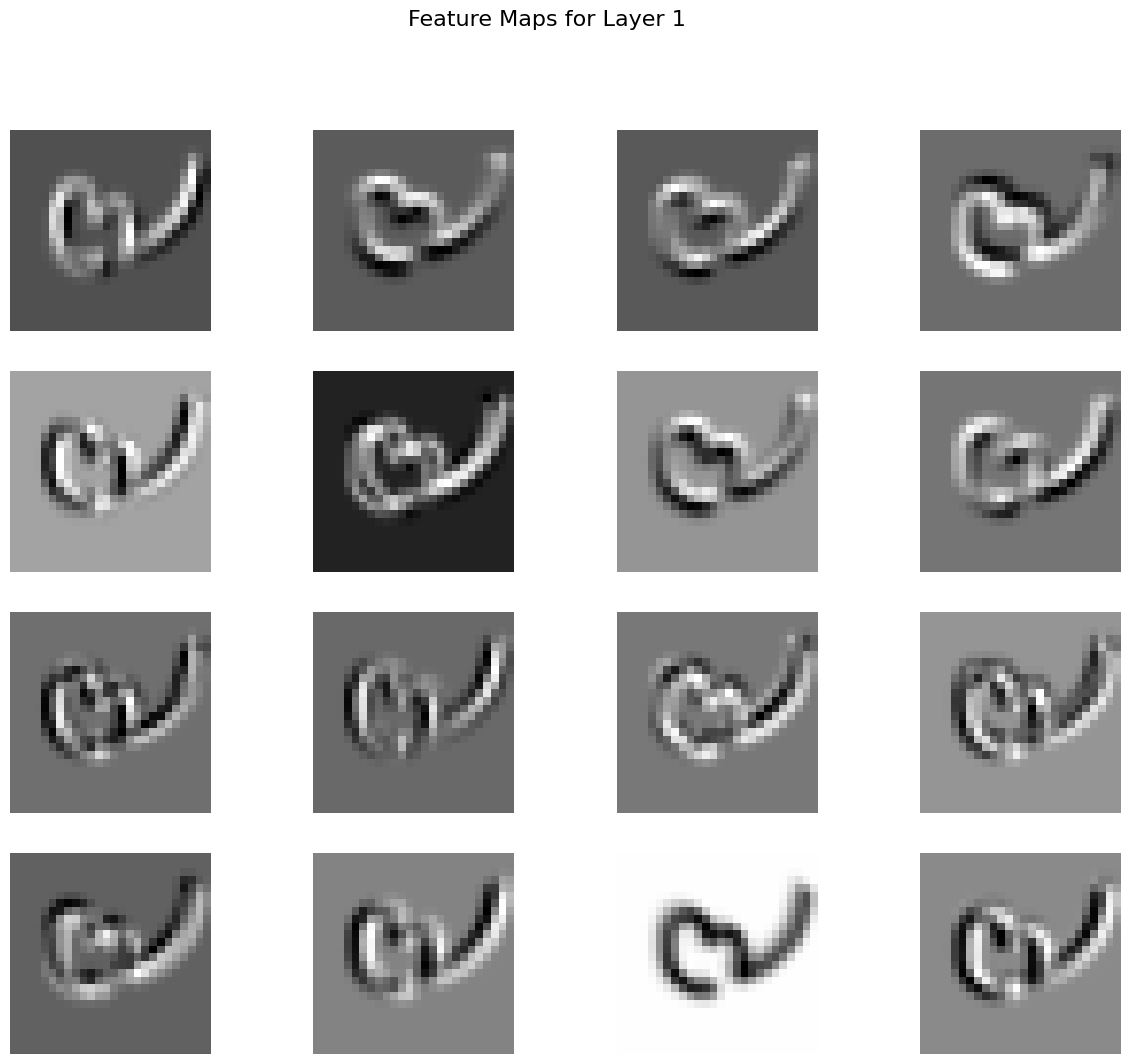

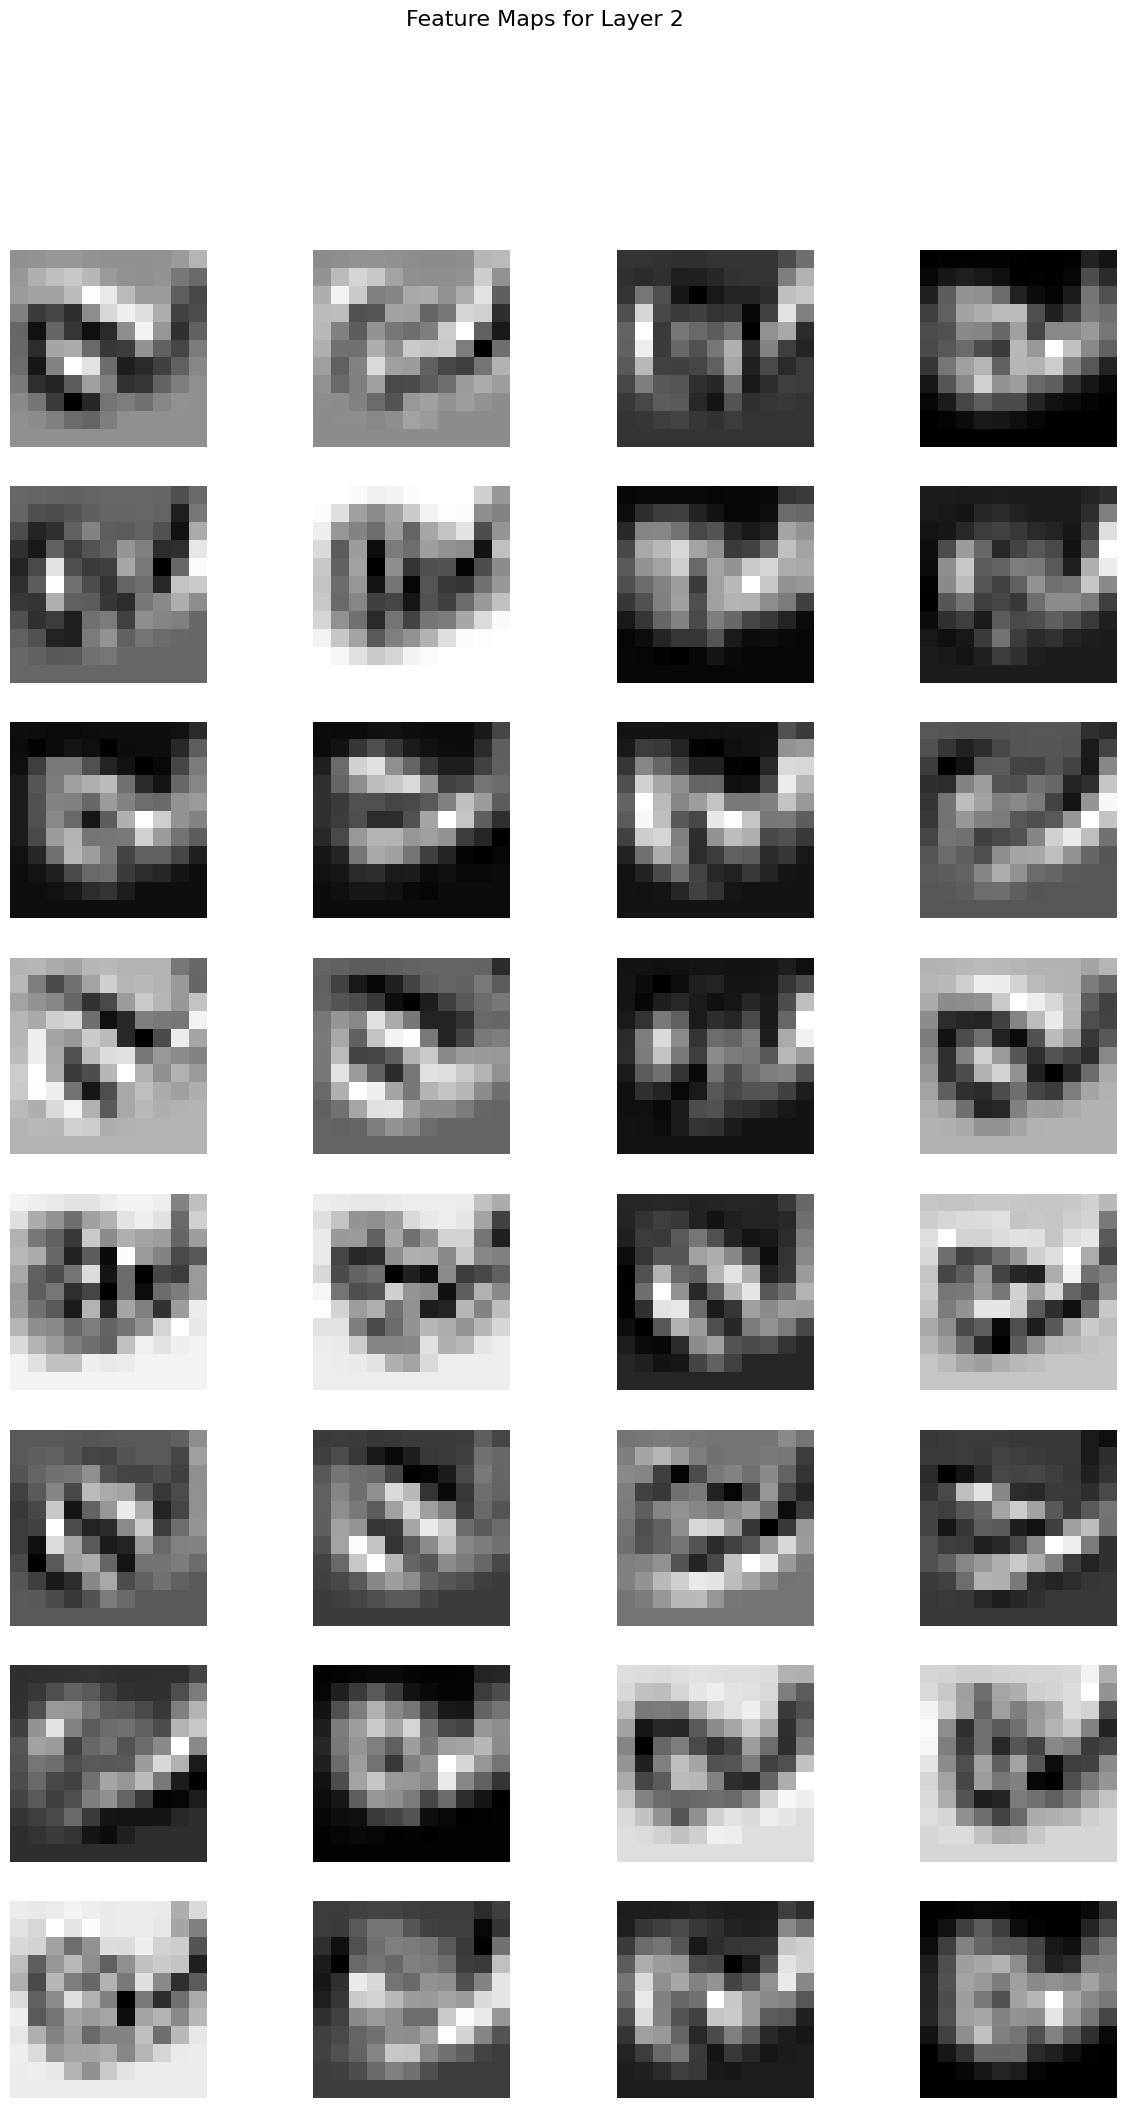

In [66]:
### START CODE HERE ###

feature_maps = []

def hook_fn(module, input, output):
    feature_maps.append(output.cpu().detach())

model.conv1.register_forward_hook(hook_fn)
model.conv2.register_forward_hook(hook_fn)

sample_image, _ = next(iter(test_loader))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
sample_image = sample_image.to(device)
model.to(device)

with torch.no_grad():
    model(sample_image)

def visualize_feature_maps(feature_maps):
    for i, fmap in enumerate(feature_maps):
        num_channels = fmap.shape[1]
        cols = 4
        rows = (num_channels + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
        fig.suptitle(f"Feature Maps for Layer {i+1}", fontsize=16)

        axes = axes.flatten() if rows > 1 else axes
        
        for j in range(num_channels):
            ax = axes[j]
            ax.imshow(fmap[0, j].cpu().detach().numpy(), cmap='gray')
            ax.axis('off')

        for ax in axes.flat[num_channels:]:
            ax.axis('off')

        plt.savefig(f'fmap/feature_map_layer_{i+1}.png')
        plt.show()

visualize_feature_maps(feature_maps)

### END CODE HERE ###

---
# Questions
1. Identify the top 3 classes with the worst F1 scores and perform an in-depth analysis of the model’s behavior on misclassified images. Analyze the feature map of an incorrectly predicted image from each class and compare it with the feature map of a correctly predicted image from the same class.
2. Does a deeper model always lead to better performance? Discuss this by considering factors such as overfitting, training time, data complexity, and model capacity. Provide examples from relevant experiments to support your argument.


### 1. Top 3 classes with the worst F1

- **F1 Score per class**: [0.7870, 0.7699, 0.8230, 0.7727, 0.6326, 0.7130, 0.6483, 0.8057, 0.6791, 0.8348]

- **Top 3 classes with the worst F1**: class 4 F1 score = 0.6326 class 6 F1 score = 0.6483 class 8 F1 score = 0.6791

### Confusion Matrix
```
[[85  9  2  4  0  0 13  1  3  0]
 [ 4 92  4  6  1  3  5  1  3  0]
 [ 0  0 86  4  0  0  8  2  3  1]
 [ 3  3  2 85  0  0  2  4  3  0]
 [ 1  2  1  1 68 26  6  0 21  3]
 [ 1  1  1  1  7 82  9  1  9  2]
 [ 1  9  8  1  1  2 94  0  4  1]
 [ 3  0  0  9  0  0  9 85  5  1]
 [ 1  2  1  2  8  0 13  2 91  4]
 [ 0  2  0  5  1  3 10  3  2 96]]
```

### 2. Does a deeper model always lead to better performance?

- **Overfitting**: Deeper model อาจจะ predict data ที่ใช้ train ได้ดีเเต่เมื่อเจอกับ data ที่ไม่เคยเจอ อาจจะ predict ไม่ถูกต้องเนื่องจาก overfitting เช่นเวลาที่เจอกับ validation/test set เเล้ว accuracy ต่ำลง

- **Training Time**: Deeper model จะใช้เวลาในการ train มากกว่าเนื่องจากมีความซับซ้อนมากกว่า

- **Data Complexity**: Deeper model อาจจะมีประโยชน์เเค่สำหรับ data ที่มีความซับซ้อนมากบางอย่าง

- **Model Capacity**: Deeper model ไม่ได้รับประกันว่าจะสามารถเรียนรู้ข้อมูลที่มีความซับซ้อนมากได้ ต้องมีการ tune hyperparameter ร่วมด้วย